In [ ]:
# !pip install trackpy pyspm

In [48]:
import cv2
import pims
import pySPM as spm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc   ### added rc
from matplotlib.animation import FuncAnimation
import matplotlib as mpl 
import pandas as pd
import seaborn as sns
import os
from ipywidgets import *
from IPython.display import display, clear_output, HTML   ### added HTML
import IPython
import trackpy as tp
import deeptrack as dt
from tensorflow import keras
from tensorflow.keras import backend as K
from scipy.stats import norm, linregress   ### added norm and lingregress

%matplotlib inline

### added all these plot style tweaks
rc('animation', html='html5')
rc('image', cmap='gray')
rc('image', origin='lower')
rc('text',color='black')

%load_ext autoreload
%autoreload 2

from sxmreader import SXMReader
from analyzer import MotionAnalyzer
from diffusion_plotter import DiffusionPlotter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
class ImageData:
    
    def __init__(self, foldername, setrange):
        self.foldername = foldername
        self.setrange = setrange
        self.filenames = [self.foldername+"/Image_{0:03}.sxm".format(i) for i in self.setrange]
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.smallest = 9999999
        self.channel = "Z"
        self.zdata = []
        for j, s in enumerate(self.scans):
            scan = s.get_channel(self.channel).correct_lines().pixels
            with open(self.filenames[j], 'r', encoding='latin-1') as f:
                lines = f.readlines()
            scan_up = [
                lines[i+1 % len(lines)] for i, x in enumerate(lines) if x == ":SCAN_DIR:\n"
                ][0].strip() == "up"
            if not scan_up:
                scan = scan[::-1]
            self.smallest = min(self.smallest, scan.shape[0])
            self.zdata.append(scan)
        self._len = len(self.zdata)
        self._dtype = np.float32
        self.frame_shape = (self.smallest, self.smallest)
        self.scan_size = self.scans[0].size
        self.nm_per_pixel = (self.scan_size['real']['x']/ self.smallest) * 1e9
        self.frames = dt.NormalizeMinMax(-1.0, 1.0).resolve(list(self.zdata))
        
        #get frames for the model
        def _frames_for_model():
            for i in self.zdata:
                z_data = [i for i in self.zdata]
            inputframes = np.stack(z_data, axis=0)
            inputframes = np.expand_dims(inputframes[:], axis=-1)
            inputframes = dt.NormalizeMinMax(0, 1).resolve(list(inputframes))
            return inputframes
        self.pframes = _frames_for_model()

nsize = 6
voltstemps = []
setranges = []
imsets = []
locs = []
links = []
dlinks = []
msize = []
minmass = []
sep = []
tthresh = []
pthresh = []
srange = []
memory = []
astop = []
astep = []
anchors = []
drifts = []

In [50]:
''' Step 1: Get the imsets image data '''

folder = 'electromigration_11'
start = 15
bsize = 30
voltstemps = np.linspace(5.5, 6.25, nsize, dtype=np.float32)
setranges = [range(start + 1 + bsize  * i, start + bsize * (i + 1)) for i in range(len(voltstemps))]

print(voltstemps)
print(setranges)

imsets.clear()
for i in range(nsize):
    imsets.append(ImageData(folder, setranges[i]))

[5.5  5.65 5.8  5.95 6.1  6.25]
[range(16, 45), range(46, 75), range(76, 105), range(106, 135), range(136, 165), range(166, 195)]


In [51]:
imsets[0].frame_shape

(128, 128)

(128, 128)


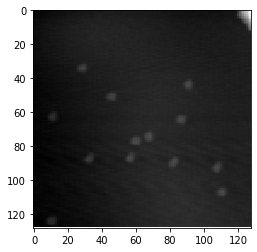

In [52]:
#imsets have the normalized (-1,1) zdata frames and normalized (0,1) frames for the trained model
index = 4
frame = 28
fsize = imsets[index].frames[0].shape
print(fsize)
plt.imshow(imsets[index].frames[frame], cmap='gray')
plt.ylim(fsize[0], 0);

In [53]:
''' Step 2: Get the locs from the prediction masks provided by the trained model '''

def iou_coef(y_true, y_pred, smooth=1):
            intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
            union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
            iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
            return iou
        
#initiate trained model
weighted_loss = dt.losses.flatten(dt.losses.weighted_crossentropy((10,1)))
model = keras.models.load_model(
    os.getcwd()+'/motionanalyze_model/iou-0.9181_epoch-100_N-49_32-64-128-256_512_lossWL-BCE_bs32_nob75_lrsLIN_doREG.hdf5',
    custom_objects={
        'nd_unet_crossentropy': weighted_loss,
        'iou_coef': iou_coef
        })

locs.clear()
tp.quiet()
for j in range(nsize):
    predictions = model.predict(
                np.array(imsets[j].pframes),
                batch_size=1
                )
    masks = []
    for i in range(len(predictions[:,:,:,0])):
        prediction = predictions[i,:,:,0] > 0.95
        mask = np.squeeze(prediction) #*1.0
        masks.append(mask)
#         masks.append(cv2.resize(mask, dsize=imsets[0].frame_shape, interpolation=cv2.INTER_NEAREST))
    locs.append(tp.batch(
        masks,
        3,
        minmass=1.0,
        separation=2.0,
        characterize=True,
        threshold=0.06
        ))

In [ ]:
test = locs[0].copy()

In [ ]:
test.dtype

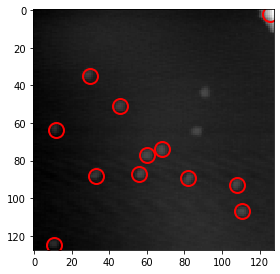

In [55]:
#prediction masks from the trained model is run through tp.batch to get particle locations
locnum = 4

fig1, ax1 = plt.subplots(figsize=(4, 4), tight_layout=True)
ln1, = ax1.plot([], [], lw=3)

def update1(i):
    tp.annotate(
        locs[locnum][locs[locnum]['frame']==i],
        imsets[locnum].frames[i],
        ax=ax1)
    for line in ax1.lines[:-1]:
        line.set_marker(None)
    return ln1,

ani = FuncAnimation(
    fig1,
    update1,
    frames=np.linspace(0,len(imsets[locnum].frames)-1,2, dtype=np.int), #range(8),
    blit='True',
    interval=300)

ani.save('sin.gif', writer='imagemagick')

In [21]:
''' Step 3: Get links from the locs in the last step '''

links.clear()

for j in range(nsize):
    links.append(
        tp.link(
            locs[j],
            75,
            memory=5,
            adaptive_stop=2,
            adaptive_step=0.95
        ))

In [22]:
links[0]

,y,x,mass,size,ecc,orientation,angle,signal,raw_mass,ep,frame,particle
0,15.008911,93.033663,3.044283,0.871439,0.302477,-0.025092,2.094395,0.732436,5.0,0.000000,0,0
17,122.057449,48.027264,3.095524,0.872048,0.282971,-0.071405,2.094395,0.741479,5.0,0.000000,0,1
16,113.027264,109.057449,3.095524,0.872048,0.346991,-1.499391,2.094395,0.741479,5.0,0.000000,0,2
15,91.980170,89.926346,3.191976,0.874030,0.352287,-1.518855,2.094395,0.753535,5.0,0.000000,0,3
14,90.809659,5.809659,2.121956,0.879049,0.294118,-0.785398,2.094395,0.611871,3.0,0.000000,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
455,3.791349,45.033079,2.484631,0.830402,0.845018,1.548879,4.188790,0.771311,5.0,0.003199,28,14
454,2.930864,125.838272,2.560498,0.849837,0.167521,-0.026588,0.000000,0.806083,4.0,0.003999,28,19
471,113.026519,106.973481,2.860803,0.871907,0.315407,0.785398,4.188790,0.685961,5.0,0.003199,28,2
462,64.791083,78.034395,2.481470,0.830164,0.844732,1.547913,4.188790,0.771311,5.0,0.003199,28,21


In [ ]:
test = tp.filter_stubs(links[0], 0)

In [ ]:
test

In [ ]:
#particle labels from links
index=6
fig, ax = plt.subplots(figsize=(5, 5))
ln, = ax.plot([], [], lw=3)

def update(i):
    mpl.rcParams.update({'font.size': 12, 'font.weight':'bold'})
    for txt in ax.texts:
        txt.set_visible(False)
    tp.plot_traj(
        links[index][links[index]['frame']==i],
        superimpose=None,
        label=True,
        ax=ax
        )
    tp.annotate(
        locs[index][locs[index]['frame']==i],
        imsets[index].frames[i],
        ax=ax
        )
    ax.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'b'])
#     tp.plot_traj(
#         links[index][links[index]['frame']<=i],
#         superimpose=None,
#         label=True,
#         ax=ax
#         )
    for txt in ax.texts:
        txt.set_fontsize(24)
        txt.set_color('darkorange')
    for line in ax.lines:
        line.set_markersize(1)
    for line in ax.lines[:-1]:
        line.set_marker(None)    
    return ln,

ani = FuncAnimation(
    fig,
    update,
    frames=range(len(imsets[index].frames)),
    blit='True',
    interval=300)
ani

In [ ]:
#plot of trajectories corresponding to links
index = 6
fig, ax = plt.subplots(figsize=(5,5))
tp.plot_traj(links[index], ax=ax);

In [ ]:
# for i in range(nsize):
#     links[i] = tp.filter_stubs(links[i], 2)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
tp.plot_traj(links[index], ax=ax);

In [ ]:
''' Step 4A: If no anchor, subtract overall drift to get average positions of particles

    These need the following plots:
    
    drift_vectors - (plots overall xy drift at each voltage/temperature iteration)
    drift_scalars - (2 plots - one for drift velocity and one for drift velocity projected to the mean axis) ???
    diffusion - (2 plots - one for diffusion constant and one for its log) ???
    msd - (plots the mean-square displacement over lag time) ???is this similar to relaxation time???
    ed - (3 plot - gives enembeled averages for vx, vy, and MSD)
    v_over_D - (3 plots - D vs V, v_drift vs V, and v_drift/D vs V)
'''
DIFFUSION_TIME = 1
MPP = imsets[0].nm_per_pixel

drifts.clear()
dlinks.clear()
for j in range(nsize):
    d_na = tp.compute_drift(links[j])
    d_na.loc[0] = [0,0]
    drifts.append(d_na)
    dlinks.append(tp.subtract_drift(links[j].copy(), d_na)) #MPP
    
    
''' drifts should only be x and y values right? '''
''' So we get links (links), then we get the overall drift (odrift),
    then we subtract odrift from links which we scale by multiplying by NM_PER_PIXEL (d_links).
    Confirming that for plots (and for calculating D below) we use the drift corrected links (d_links) right?
    We only need the x and y values from this dataframe correct?
'''
''' There are two methods in MotionAnalyzer for calculating D '''

In [ ]:
dlinks[0]

In [ ]:
#plot subtracted drifts
index = 0
tp.plot_traj(dlinks[index]);

In [ ]:
''' Step 4B: If there is an anchor, subtract overall drift from anchor instead '''

# for j in range(nsize):
#     anchor = links[0][links[0].particle == ANCHOR_NUMBER]
#     d_ya = tp.compute_drift(anchor)
#     d_ya.loc[0] = [0,0]
#     drifts.append(d_ya)
#     dlinks.append(tp.subtract_drift(links[j].copy(), d_ya)) #* MPP

In [ ]:
''' Step 5: Calculate D (Note there are two ways listed) '''

### Method 1 of calculating D: variance of all displacements of Delta_t=1
displacements1 = []
D_constants1 = []
mu_hats = []

def calculate_displacements(n, t):
    displacements = pd.DataFrame()
    for j in range(t.frame.max() - 1):
            displacements = displacements.append(
                tp.relate_frames(t, j, j + 1) * MPP,
                ignore_index=True
                )
    return displacements

for j in range(nsize):
    dlc = dlinks[j].copy()
    displacements1.append(calculate_displacements(j, dlc))

for d in displacements1:
    D_constants1.append(
        (d.dx.var() + d.dy.var()) / 4
        ) # r^2 = x^2 + y^2 = 2Dt + 2Dt
    mu_hats.append(
        np.mean(d[['dx', 'dy']], axis=0)
        )

In [ ]:
from scipy.stats import linregress

### Method 2 of calculating D: linear fit to MSD
em = []
ed = []
msd_slope = []
msd_intercept = []
D_constants2 = []

for j in range(nsize):
    em0 = tp.emsd(dlinks[j], MPP, DIFFUSION_TIME, max_lagtime=len(imsets[j].frames), detail=True)
    em.append(em0)
    ed.append([em0['<x>'], em0['<y>']])
    result = linregress(em0.index[:-8] * DIFFUSION_TIME, em0['msd'][:-8])
    msd_slope.append(result.slope)
    msd_intercept.append(result.intercept)
    D_constants2.append(result.slope/4)

In [ ]:
''' plot_drift_vectors plot '''

def plot_drift_vectors(plotrange = 20):
        mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
        plt.figure(figsize=(10, 10))
        #colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
        cmap = plt.cm.get_cmap("magma")
        colors = cmap(np.linspace(0, 0.8, nsize))

        arrs = []
        j = 0
        for d in drifts:
            for i in range(1, len(d)):
                d0, d1 = d.loc[i - 1] * MPP, d.loc[i] * MPP
                plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5, linewidth=1)
            else:
                d0, d1 = d.loc[i - 1] * MPP, d.loc[i] * MPP
                arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5, label=str(voltstemps[j])))
            j += 1
        new_labels, arrs = zip(*sorted(zip(voltstemps, arrs)))
        new_labels=["{:.2f}".format(s) + ' V' for s in new_labels]
        plt.legend(arrs, new_labels, fontsize=16, loc='upper left')
        #plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
        plt.xlabel("x (nm)",fontsize=24,fontweight='bold')
        plt.ylabel("y (nm)",fontsize=24,fontweight='bold')
        plt.xlim(-plotrange, plotrange)
        plt.ylim(-plotrange, plotrange)
#         plt.savefig(self.ANALYSIS_FOLDER + "drift_vectors.png")
        
plot_drift_vectors()

In [ ]:
''' plot_drift_scalar plot '''

def calculate_mean_axis(mu_hats):
        return sum(mu_hats)/len(mu_hats)
    
def project_to_mean_axis(mu_hats, mean_mu_hat):
        return [np.dot(v, mean_mu_hat) for v in mu_hats]

def plot_drift_scalar(**kwargs):
    mag_displace = np.linalg.norm(mu_hats, 2, axis=1)
    new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(voltstemps, mag_displace, D_constants1)))
    mpl.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
    plt.figure(figsize=(10, 10))
    plt.plot(voltstemps, mag_displace / DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
    # plt.plot(xx, yy / 1.5)
    plt.ylabel('drift velocity (nm / s)')
    plt.xlabel('Voltage (V)')
#     plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar.png")

    plt.figure(figsize=(10, 10))
    mean_mu_hat = calculate_mean_axis(mu_hats)
    proj_mag_displace = np.array(project_to_mean_axis(mu_hats, mean_mu_hat))
    plt.plot(voltstemps, proj_mag_displace / DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
    plt.ylabel('drift velocity (nm / s)')
    plt.xlabel('Voltage (V)')
#     plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar_projected.png")

plot_drift_scalar()

In [ ]:
''' diffusion plot '''

heater = False

def label_axes(ax, xlabel, ylabel):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

def plot_diffusion(heater=False):
    font = {
    'weight' : 'bold',
    'size'   : 22}

    mpl.rc('font', **font)
    mpl.rc('text', usetex =True)
    fig, ax = plt.subplots(figsize=(10,10))
    tmpv, sorted_D_constants1 = (list(t) for t in zip(*sorted(zip(voltstemps, D_constants1))))
    tmpv, sorted_D_constants2 = (list(t) for t in zip(*sorted(zip(voltstemps, D_constants2))))
    ax.plot(np.array(tmpv), sorted_D_constants1,'o-', label='variance')
    ax.plot(np.array(tmpv), sorted_D_constants2,'o-', label='msd slope')
    ax.legend()

    if heater == True:
        label_axes(ax, 'Temperature (K)', 'Diffusion constant ($nm^2$ / s)')
    else:
        label_axes(ax, 'Voltage (V)', 'Diffusion constant ($nm^2$ / s)')
#     plt.savefig(self.ANALYSIS_FOLDER + "D_constant_exp.png")

    fig, ax1 = plt.subplots(figsize=(10,10))
    sns.regplot(np.reciprocal(tmpv), np.log(sorted_D_constants1), 'o-', ci=None, ax=ax1)
    sns.regplot(np.reciprocal(tmpv), np.log(sorted_D_constants2), 'o-', ci=None, ax=ax1)
    result = linregress(np.reciprocal(tmpv), np.log(sorted_D_constants1))
    result2 = linregress(np.reciprocal(tmpv), np.log(sorted_D_constants2))

    if heater == True:
        label_axes(ax1, '1/T (1/K)', 'Log Diffusion constant ($nm^2$ / s)')
        ax1.annotate(r'ln(D)= {slope:.2f} $\frac{{1}}{{T}}$+ {intercept:.2f}'.format(slope=result.slope,intercept = result.intercept),xy=(350,500), xycoords='figure pixels')
        ax1.annotate(r'ln(D)= {slope:.2f} $\frac{{1}}{{T}}$+ {intercept:.2f}'.format(slope=result2.slope,intercept = result2.intercept),xy=(350,400), xycoords='figure pixels')
    else:
        label_axes(ax1, '1/V (1/V)', 'Log Diffusion constant ($nm^2$ / s)')
        ax1.annotate(r'ln(D)= {slope:.2f} $\frac{{1}}{{T}}$+ {intercept:.2f}'.format(slope=result.slope,intercept = result.intercept),xy=(350,500), xycoords='figure pixels')
        ax1.annotate(r'ln(D)= {slope:.2f} $\frac{{1}}{{T}}$+ {intercept:.2f}'.format(slope=result2.slope,intercept = result2.intercept),xy=(350,400), xycoords='figure pixels')
#         plt.savefig(self.ANALYSIS_FOLDER + "logD_constant_lin.png")

plot_diffusion(heater)

In [ ]:
''' msd - (plots the mean-square displacement over lag time) '''

def plot_msd():
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(len(em)):
        ax.plot(em[i].index * DIFFUSION_TIME, em[i]['msd'], 'o-', label= "{:.2f} $V_S$".format(voltstemps[i]))
        ax.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
        xlabel='lag time $t$')
        x = np.linspace(DIFFUSION_TIME, DIFFUSION_TIME * em[i].index, 100)
        ax.plot(x, msd_slope[i]*x + msd_intercept[i], 'b--')
#     plt.savefig(self.ANALYSIS_FOLDER + "msd.png")

plot_msd()

In [ ]:
''' ed - (3 plot - gives enembeled averages for vx, vy, and MSD) '''

def plot_ed():
    fig, axs = plt.subplots(3, 1, figsize=(12,16))
    t = [i for i in range(1,len(ed[0][0])+1)]
    vx = []
    vy = []
    for i, volt in enumerate(voltstemps):
        slope, intercept, _, _, _ = linregress(t[:-5], ed[i][0][:-5])
        #print("vx={:.2f}nm/s".format(slope))
        vx.append(slope)
        slope, intercept, _, _, _ = linregress(t[:-5], ed[i][1][:-5])
        #print("vy={:.2f}nm/s".format(slope))
        vy.append(slope)
    mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
    
    axs[0].plot(voltstemps, vx, 'o-')
    axs[0].set_title('ensemble averaged vx')
    axs[1].plot(voltstemps, vy, 'o-')
    axs[1].set_title('ensemble averaged vy')
    axs[2].plot(voltstemps, np.array(vx)**2 + np.array(vy)**2, 'o-')
    axs[2].set_title('ensemble averaged msd')

    for i in range(3):
        axs[i].set_xlabel('voltage(V)')
        axs[i].set_ylabel('velocity (nm/s)')
        if i == 2:
            axs[i].set_ylabel('velocity (nm/$s^2$)')
    
    fig.tight_layout(pad=2.0)
#     plt.savefig(self.ANALYSIS_FOLDER + "ensemble averaged v.png")

plot_ed()

In [ ]:
from scipy.optimize import curve_fit

''' v_over_D - (3 plots - D vs V, v_drift vs V, and v_drift/D vs V) '''

def plot_v_over_D():
        
    def exponenial_func(x, a, b):
        return a * np.exp(-b / x )

    plt.figure(figsize=(7,5))
    popt, pcov = curve_fit(exponenial_func, voltstemps, D_constants1)

    xx = np.linspace(voltstemps[0], voltstemps[-1], 100)
    yy = exponenial_func(xx, *popt)
    plt.plot(xx, yy)
    plt.plot(voltstemps, np.array(D_constants1), 'o')
    plt.xlabel('$V_{SD} (V)$')
    plt.ylabel('$D (nm^2/s)$')

    plt.figure(figsize=(7,5))
    mag_displace = np.linalg.norm(mu_hats, 2, axis=1)
    popt1, pcov1 = curve_fit(exponenial_func, voltstemps, mag_displace)
    yy1 = exponenial_func(xx, *popt1)
    plt.plot(xx, yy1)

    plt.plot(voltstemps, mag_displace , 'o')
    plt.xlabel('$V_{SD} (V)$')
    plt.ylabel('$v_{drift} (nm/s)$')

    plt.figure(figsize=(7,5))
    yy2 = exponenial_func(xx, *popt1)/exponenial_func(xx, *popt)
    plt.plot(xx, yy2)
    plt.plot(voltstemps, mag_displace/np.array(D_constants1), 'o')
    plt.xlabel('$V_{SD} (V)$')
    plt.ylabel('$v_{drift}/D \ (1/nm)$')
    
plot_v_over_D()